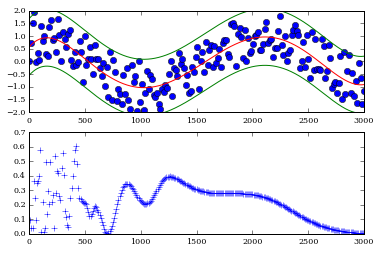

In [4]:
%matplotlib inline
#code goes here
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap


#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Generate Data

x = np.linspace(0, 3000, num=200, endpoint=True)
y = np.cos(x*0.003)
for i in range(len(y)):
    r = np.random.random()
    if r < 0.5:
        y[i] -= np.random.random()
    else:
        y[i] += np.random.random()

period = np.array([i for i in range(10,3000,10)])
omega = 2 * np.pi / period
yerr = [np.random.random()/2 for i in y]

PS = lomb_scargle(x, y, yerr, omega, generalized=True)

p = np.poly1d(np.polyfit(x,y,5))
xp = np.arange(0,3000,1)

#calculate y difference
dy = []
for i in range(len(y)):
    dy.append(abs(y[i]-p(x[i])))
    if dy[i] < yerr[i]:
        dy[i] = 0
    else:
        dy[i] -= yerr[i]
        
S=y-p(x)
sigma=0.0
for i in range(len(y)):
    sigma+=S[i]**2
sigma=sigma/len(y)
sigma=np.sqrt(sigma)

plt.subplot(211)
plt.plot(x, y, 'o',xp,p(xp),'r-',xp,p(xp)+2*sigma,'g-',xp,p(xp)-2*sigma,'g-')
plt.ylim((-2,2))

plt.subplot(212)
plt.plot(period,PS,'+')

plt.show()